In [1]:
from datascience import *
import numpy as np
%matplotlib inline

## Group Mentoring

**Please run all cells before this cell, including the import cell at the top of the notebook.**

In [2]:
scores = Table.read_table("scores.csv")
scores.show(5)

Midterm 1,Midterm 2,Mentored
28,20,False
28.5,35,False
23.5,13.5,False
24.5,22.5,True
28.5,35.5,True


#### Let's take a look at the two groups of students that signed up for 1:1 mentoring AFTER Midterm1 exams vs that didn't.

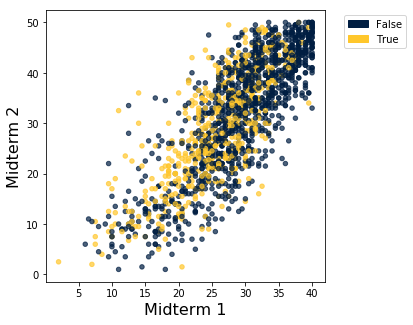

In [3]:
scores.scatter('Midterm 1', 'Midterm 2', colors='Mentored')

#### Question we're trying to answer: did 1:1 mentoring help improve students' scores in Midterm2? Or is any improvement just a coincedence? The association (chart above) doesn't seem to be quite linear, so Linear Regression doesn't sound like a good approach. 

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


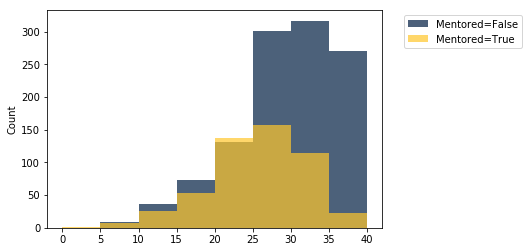

In [15]:
scores.hist('Midterm 1', group='Mentored', bins=np.arange(0, 41, 5), normed=False)

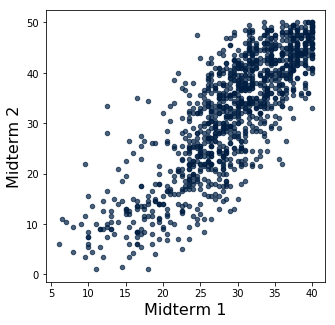

In [16]:
scores.where('Mentored', False).scatter('Midterm 1', 'Midterm 2')

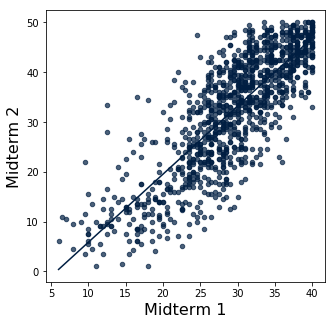

In [17]:
control = scores.where('Mentored', False)
control.scatter('Midterm 1', 'Midterm 2', fit_line=True)

#### How can we decide whether there is a LINEAR association or not? We look at residual plot!

In [19]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers < np.mean(any_numbers)) / np.std(any_numbers)

# Below t is a table; x and y are column indices or labels.

def correlation(t, x, y):
    """The correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x))) * standard_units(t.column(y))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fitted_values(t, x, y):
    """The fitted values along the regression line."""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b

def residuals(t, x, y):
    return t.column(y) - fitted_values(t, x, y)

def plot_residuals(t, x, y):
    with_residuals = t.with_columns(
        'Fitted', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    with_residuals.select(x, y, 'Fitted').scatter(0)
    with_residuals.scatter(x, 'Residual')

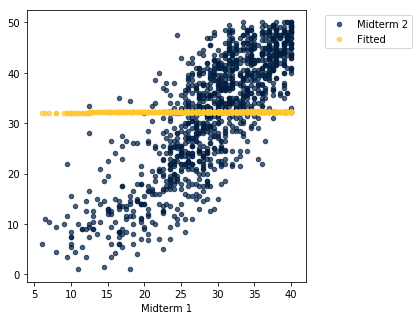

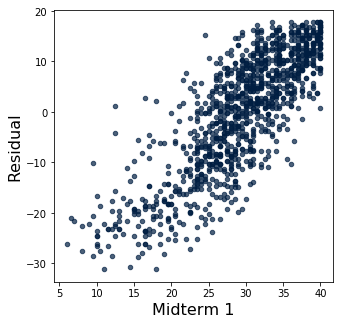

In [20]:
plot_residuals(control, 'Midterm 1', 'Midterm 2')

#### The residual plot also shows that the association is not really linear. How? Revisit the Residual Plots chapter in the course book(https://www.inferentialthinking.com). Also watch Prof. Ani Adhikari's YouTube lecture on Residuals (Fall 2016 Data8 recordings).

#### One approach we can take is to use the mean-based prediction model to predict average Midterm2 scores for the Mentored group, using the non-Mentored group's Midterm2 scores and finding any imporvement as the difference between the predicted and actual scores for the Mentored group. Use a neighborhood of "2" to calculate the average scores. They'll be helpful in drawing the line of averages. <br><br> Note!!: If we don't use the neighborhood of "2" to calculate the average predicted scores and instead use "are.equal(mt1)" instead, the averages line will be more sqiggly and will contain some noise. 

In [22]:
examples = scores.where("Mentored", False)

def predict_mt2(mt1):
    near = examples.where("Midterm 1", are.between_or_equal_to(mt1-2, mt1+2))
    return near.column("Midterm 2").mean()

predict_mt2(30)

34.11057692307692

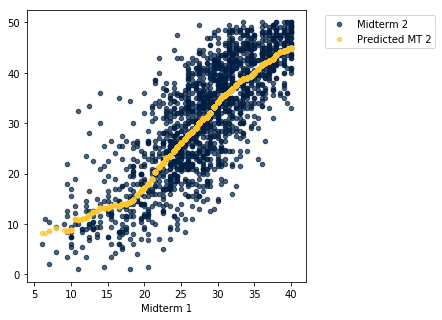

In [23]:
mt1_scores = examples.select("Midterm 1").sort(0, distinct=True)
predictions = mt1_scores.with_column("Predicted MT 2", mt1_scores.apply(predict_mt2, "Midterm 1"))
t = scores.join("Midterm 1", predictions)
t.drop("Mentored").scatter(0)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


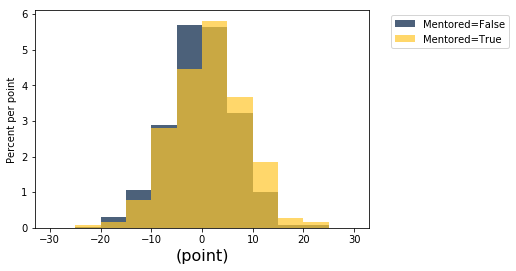

In [24]:
u = t.with_column("Improvement", t.column("Midterm 2") - t.column("Predicted MT 2"))
u.hist("Improvement", bins=np.arange(-30, 31, 5), group="Mentored", unit="point")

In [25]:
def of_at_least_5(values):
    return sum(values >= 5) / len(values)

u.select(2, 4).group("Mentored", of_at_least_5).set_format(1, PercentFormatter)

Mentored,Improvement of_at_least_5
False,21.90%
True,29.63%


In [26]:
u.group("Mentored", np.mean)

Mentored,Midterm 1 mean,Midterm 2 mean,Predicted MT 2 mean,Improvement mean
False,29.3461,32.2821,32.3047,-0.0226162
True,25.5945,28.5629,27.082,1.48083


#### Next, we find the confidence interval and take the middle 95% confidence interval. If 0 is not in the confidence interval, we can infer that there is some association between tutoring and students performing better in Midterm2. Whether there is causation, we'll need more data and more analysis but the fact that there is correlation is good enough to make us investigate this phenomenon further.

In [27]:
def mean_ci(observations):
    means = []
    for i in np.arange(2000):
        means.append(observations.sample().column("Improvement").mean())
    lower, upper = percentile(2.5, means), percentile(97.5, means)
    print("Mean improvement:", observations.column("Improvement").mean())
    print("95% CI of mean improvement:", lower, "to", upper)

mentored = u.where("Mentored", True)
mean_ci(mentored)

Mean improvement: 1.4808291598569334
95% CI of mean improvement: 0.8657377070863601 to 2.093290545736067
